# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn

import scienceplots
plt.style.use(['science','no-latex'])

# Query the current default figure size
current_fig_size = plt.rcParams["figure.figsize"]
print(f"Current default figure size: {current_fig_size}")

# Define a scalar factor
scalar_factor = 1.5

# Multiply the current figure size by the scalar factor
new_fig_size = [size * scalar_factor for size in current_fig_size]

# Set the new default figure size
plt.rcParams["figure.figsize"] = new_fig_size

print(f"New default figure size: {new_fig_size}")


import numpy as np
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

from sklearn import datasets, decomposition

Current default figure size: [3.5, 2.625]
New default figure size: [5.25, 3.9375]


In [3]:
from polcanet import LinearDecoder, PolcaNet, PolcaNetLoss
from polcanet.example_aencoders import (
    ConvEncoder,
    DenseDecoder,
    DenseEncoder,
    LSTMEncoder,
    MinMaxScalerTorch,
    StandardScalerTorch,
)

In [4]:
import polcanet.polcanet_reports as report

In [5]:
np.random.seed(5)

In [6]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

### Load dataset

In [7]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
MNIST
mnist_trainset = MNIST(root="../../data/MNIST", train=True, download=True, transform=None)

In [51]:
train_dataset = mnist_trainset.data[:-10000].reshape(-1, 1, 28, 28) / 255.0
eval_dataset = mnist_trainset.data[-10000:].reshape(-1, 1, 28, 28) / 255.0
y_train = mnist_trainset.targets[:-10000].numpy()
y_test = mnist_trainset.targets[-10000:].numpy()
X = np.array(train_dataset.numpy(), dtype=np.float32)
X = np.squeeze(X)
X_test = np.array(eval_dataset.numpy(), dtype=np.float32)
X_test = np.squeeze(X_test)
train_dataset.shape, eval_dataset.shape, X.shape,X_test.shape, y_train.shape, y_test.shape

(torch.Size([50000, 1, 28, 28]),
 torch.Size([10000, 1, 28, 28]),
 (50000, 28, 28),
 (10000, 28, 28),
 (50000,),
 (10000,))

In [9]:
train_dataloader = DataLoader(X, batch_size=512, shuffle=True,num_workers=4)
test_dataloader = DataLoader(X_test, batch_size=512, shuffle=True)

### Fit standard sklearn PCA

In [10]:
n_components = int(np.prod(X.shape[1:]) // 2)
pca = decomposition.PCA(n_components=n_components)
pca.fit(np.squeeze(X.reshape(X.shape[0], -1)))
Xpca = pca.transform(X.reshape(X.shape[0], -1))
print("n-components",n_components)
pca.explained_variance_ratio_

n-components 392


array([9.74410772e-02, 7.06001744e-02, 6.21617325e-02, 5.37929833e-02,
       4.85727191e-02, 4.31970917e-02, 3.27737629e-02, 2.88645048e-02,
       2.76874825e-02, 2.36597471e-02, 2.09956300e-02, 2.02042572e-02,
       1.71583295e-02, 1.68181732e-02, 1.57929584e-02, 1.49278957e-02,
       1.31819658e-02, 1.27654802e-02, 1.18653821e-02, 1.15104755e-02,
       1.06913261e-02, 1.00752423e-02, 9.53652896e-03, 9.07879695e-03,
       8.82808957e-03, 8.36968608e-03, 8.17558821e-03, 7.84814917e-03,
       7.42031634e-03, 6.90722326e-03, 6.58579031e-03, 6.43667812e-03,
       6.02732971e-03, 5.85316354e-03, 5.69444243e-03, 5.41864755e-03,
       5.07321162e-03, 4.88405954e-03, 4.82065883e-03, 4.73361090e-03,
       4.55982564e-03, 4.41421056e-03, 4.16436139e-03, 3.96230631e-03,
       3.85340326e-03, 3.74073419e-03, 3.61337233e-03, 3.50477430e-03,
       3.40276468e-03, 3.21054971e-03, 3.18208244e-03, 3.10994824e-03,
       2.94579333e-03, 2.88298167e-03, 2.85749789e-03, 2.70765414e-03,
      

### Fit POLCANet

In [11]:
N = X[0].shape[0]
M = X[0].shape[1]

In [12]:
ae_input = X
act_fn = torch.nn.SiLU
input_dim = ae_input[0].shape
latent_dim = 64
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"

encoder_conv = ConvEncoder(
    input_dim=input_dim[1],
    latent_dim=latent_dim,
    conv_dim=2,
    act_fn=act_fn,
)

decoder_conv = LinearDecoder(
    latent_dim=latent_dim*4 ,
    input_dim=input_dim,
    hidden_dim=1024,
    num_layers=2,
)

model = PolcaNet(
    encoder=encoder_conv,
    decoder=decoder_conv,
    latent_dim=latent_dim*4 ,
    alpha=0.1,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=1.0,  # variance reduction loss
    device="cpu",
    # scaler = StandardScalerTorch(),
)
model

PolcaNet(
  (encoder): EncoderWrapper(
    (encoder): Sequential(
      (0): ConvEncoder(
        (encoder): Sequential(
          (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): SiLU()
          (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (3): SiLU()
          (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (5): SiLU()
          (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (7): SiLU()
          (8): Flatten(start_dim=1, end_dim=-1)
          (9): Linear(in_features=256, out_features=256, bias=True)
          (10): SiLU()
          (11): Linear(in_features=256, out_features=256, bias=True)
          (12): SiLU()
          (13): Linear(in_features=256, out_features=256, bias=True)
        )
      )
      (1): Tanh()
    )
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=256, out_features=1024, bias=False)
 

In [13]:
ae_input = X
act_fn = torch.nn.SiLU
input_dim = ae_input.shape[1:]
latent_dim = pca.n_components

encoder = DenseEncoder(
    input_dim=input_dim,
    latent_dim=latent_dim,   
    num_layers=3,
    act_fn=act_fn,
    # first_layer_size=1024,
    hidden_size=256,
)

decoder = LinearDecoder(
    latent_dim=latent_dim,
    input_dim=input_dim,
    hidden_dim=1024,
    num_layers=2,
)


model = PolcaNet(
    encoder=encoder,
    decoder=decoder,
    latent_dim=latent_dim,
    alpha=1.0,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=1.0,  # variance reduction loss
    device="cuda",
    # scaler = StandardScalerTorch(),
)
model

PolcaNet(
  (encoder): EncoderWrapper(
    (encoder): Sequential(
      (0): DenseEncoder(
        (encoder): Sequential(
          (0): Linear(in_features=784, out_features=256, bias=True)
          (1): SiLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): SiLU()
          (4): Linear(in_features=256, out_features=256, bias=True)
          (5): SiLU()
          (6): Linear(in_features=256, out_features=256, bias=True)
          (7): SiLU()
          (8): Linear(in_features=256, out_features=392, bias=True)
        )
      )
      (1): Tanh()
    )
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=392, out_features=1024, bias=False)
      (1): Linear(in_features=1024, out_features=784, bias=False)
    )
  )
  (polcanet_loss): PolcaNetLoss()
)

In [14]:
model.to("cuda")
model.train_model(data=X, batch_size=4*1024, num_epochs=5000, report_freq=10, lr=1e-3)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 4999
Total Loss: 0.01227
Reconstruction Loss: 0.00576
Orthogonality Loss: 0.004493
Center of Mass Loss: 0.001174
Variance Distribution Loss: 0.0002448


In [15]:
model.train_model(data=X, batch_size=4*1024, num_epochs=1000, report_freq=10, lr=1e-4)

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Final metrics at epoch: 999
Total Loss: 0.008333
Reconstruction Loss: 0.004218
Orthogonality Loss: 0.003526
Center of Mass Loss: 0.000329
Variance Distribution Loss: 3.614e-05


In [16]:
model.train_model(data=X, batch_size=4*1024, num_epochs=1000, report_freq=10, lr=1e-5)

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Final metrics at epoch: 999
Total Loss: 0.007989
Reconstruction Loss: 0.004114
Orthogonality Loss: 0.003371
Center of Mass Loss: 0.0002814
Variance Distribution Loss: 2.767e-05


## Evaluate results

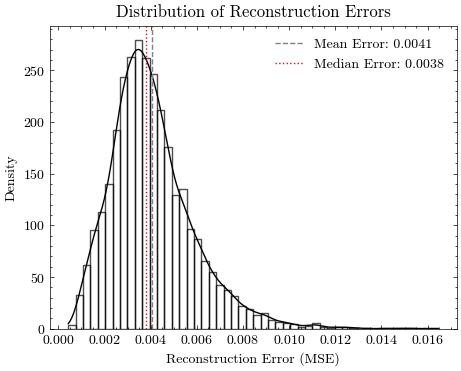

Mean Reconstruction Error: 0.0041
Median Reconstruction Error: 0.0038
Min Reconstruction Error: 0.0004
Max Reconstruction Error: 0.0165


In [38]:
report.analyze_reconstruction_error(model, X[:-20000])

In [47]:
latents, reconstructed = model.predict(X)

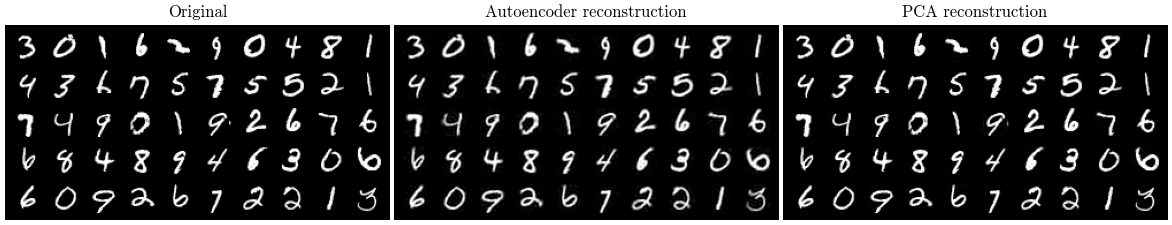

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.utils


# Function to show a single image
def show_image(ax, img):
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis("off")  # Turn off axis


# Function to visualize output images horizontally
def visualise_reconstructed_images(reconstructed_list, title_list):
    # Create a figure for all visualizations to be displayed horizontally
    fig, axs = plt.subplots(1, len(reconstructed_list), figsize=(15, 15))  # Adjust number of subplots and size as needed22
    fig.subplots_adjust(wspace=0.01)
    for ax, reconstructed, title in zip(axs, reconstructed_list, title_list):
        reconstructed = np.squeeze(reconstructed)
        reconstructed = reconstructed.clip(0, 1)
        reconstructed = torch.tensor(reconstructed)[:, None, :, :]
        # Create a grid of images for plotting
        grid = np.squeeze(torchvision.utils.make_grid(reconstructed, 10, 5))
        show_image(ax, grid)
        ax.set_title(title)
    plt.show()

# Assuming images are properly defined as before
images = torch.tensor(X_test[0:50, None, :, :]).numpy()

# Reconstruct and visualise the images using the autoencoder
_, ae_reconstructed = model.predict(np.squeeze(images))

# Reconstruct and visualize the imagaes by PCA
pca_latents = pca.transform(images.reshape(images.shape[0], -1))
pca_reconstructed = pca.inverse_transform(pca_latents)
pca_reconstructed = pca_reconstructed.reshape(images.shape[0], N, M)

visualise_reconstructed_images(  
    [images, ae_reconstructed, pca_reconstructed],
    title_list=["Original", "Autoencoder reconstruction", "PCA reconstruction"],
)


In [41]:
report.analyze_latent_space(model, latents=latents)


           Latent Space Analysis Report           

1. General Information
------------------------------
Number of latent components: 392
Total variance in latent space: 0.7652

2. Variance Analysis
------------------------------
Metric                           Value
-----------------------------  -------
First component                 0.2921
First 5 components              0.9844
Components for 95% variance     5
Variance Concentration Metric   0.9954

Variance Concentration Interpretation:
Excellent concentration of variance in earlier dimensions.

3. Orthogonality Analysis
------------------------------
Metric                                 Value
-----------------------------------  -------
Mean absolute off-diagonal            0.0418
Median absolute off-diagonal          0.0331
Max absolute off-diagonal             0.9969
Proportion of |Orthogonality| > 0.1   0.0717
Orthogonality Success Metric          0.9582

Orthogonality Interpretation:
Excellent orthogonality of features.


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: 0.0005
    - Max cosine similarity: 1.0000
    - Min cosine similarity: -1.0000
    


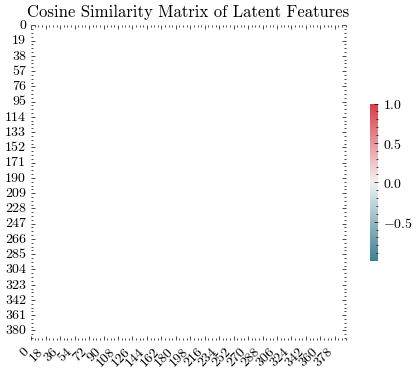

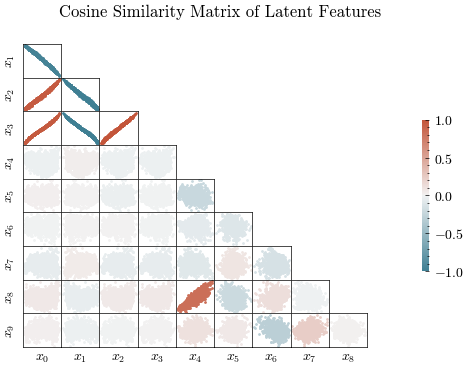

In [42]:
report.orthogonality_test_analysis(model, X)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 2.8448
    - Variance fit to exponential distribution (sum of squared differences):
     0.1521
    


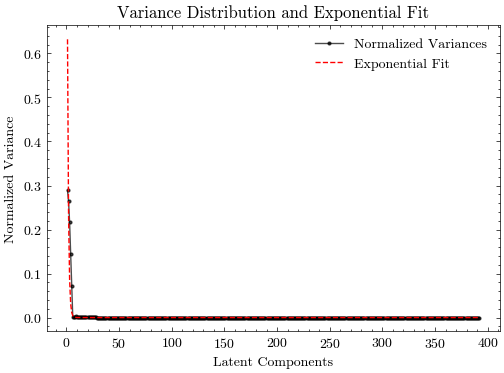

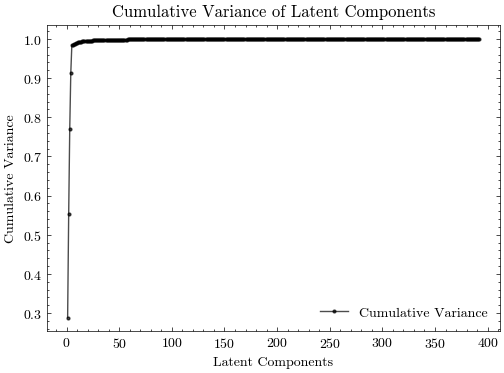

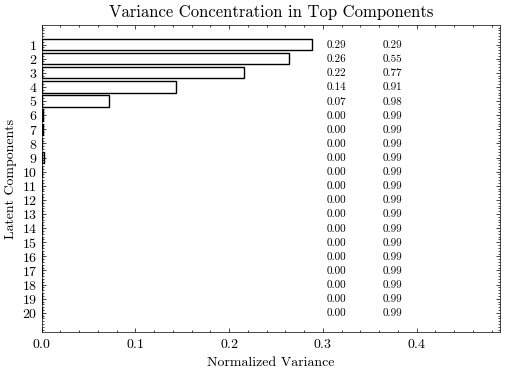

In [43]:
report.variance_test_analysis(model, X)

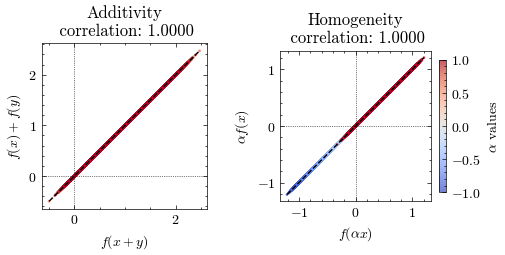

In [44]:
report.linearity_tests_analysis(model, X)

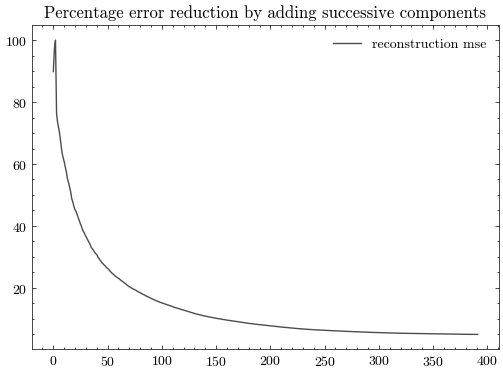

In [24]:
report.plot_cumsum_variance(model, X)

In [52]:
def plot2d_analysis(X, y, title, legend=True):
    fig = plt.figure(1, figsize=(5, 5))
    ax = fig.add_subplot(111)

    for label in range(10):
        ax.scatter(X[y == label, 0], X[y == label, 1], label=label)
        ax.set_xlabel("component: 0")
        ax.set_ylabel("component 1")
    if legend:
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.show()
    return fig, ax

In [53]:
o1 = widgets.Output()
o2 = widgets.Output()
with o1:
    _, _ = plot2d_analysis(Xpca, y_train, title="PCA transform", legend=True)
with o2:
    _, _ = plot2d_analysis(latents, y_train, title="POLCA-Net latent")
layout = widgets.Layout(grid_template_columns="repeat(2, 600px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 600px)'))

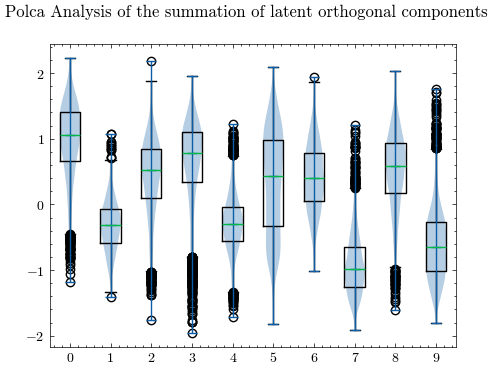

In [54]:
latents, reconstructed = model.predict(X)
vectors = []
labels = [str(i) for i in range(10)]
for c, label in enumerate(labels):
    vectors.append(np.sum(latents[y_train == c, :], axis=1))


plt.boxplot(vectors, tick_labels=labels)
plt.violinplot(vectors, showmeans=False, showmedians=True)
plt.suptitle("Polca Analysis of the summation of latent orthogonal components")
plt.show()

In [55]:
import seaborn as sns

o1 = widgets.Output()
o2 = widgets.Output()


with o1:
    scores = model.score(X)
    sns.displot(scores, kde=True)
    plt.title("Last component with clean data")
    plt.show()

with o2:
    scores = model.score(X * (np.random.random(size=X.shape) - 0.5) * 1)
    sns.displot(scores, kde=True)
    plt.title("Last componet with uniform noise in data")
    plt.show()


layout = widgets.Layout(grid_template_columns="repeat(2, 500px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 500px)'))

## Test Classification with two components on PCA vs POLCA Net

In [56]:
import pandas as pd
from scipy.stats import ttest_rel
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import minmax_scale, scale
from sklearn.svm import SVC

In [57]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_train, test_size=0.3, random_state=1)

In [58]:
X_train_pca = pca.transform(X_train.reshape(X_train.shape[0], -1))
X_test_pca = pca.transform(X_test.reshape(X_test.shape[0], -1))
X_train_pca.shape, X_test_pca.shape

((35000, 392), (15000, 392))

In [59]:
# Transform the data using POLCA-Net
# X_train_polca = model.predict(X_train,np.array([1, 1, 0, 0]))[0][:,:2]
X_train_polca = model.predict(X_train)[0][:, :pca.n_components]
# X_test_polca = model.predict(X_test, np.array([1, 1, 0, 0]))[0][:,:2]
X_test_polca = model.predict(X_test)[0][:, :pca.n_components]
X_train_polca.shape, X_test_polca.shape

((35000, 392), (15000, 392))

In [60]:
# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(solver='saga',n_jobs=30,max_iter=500),
    "Gaussian Naive Bayes": GaussianNB(),
    "Linear SVM": SVC(kernel="linear", probability=True),
    "Ridge Classifier": RidgeClassifier(),
    "Perceptron": Perceptron(n_jobs=30),
}

In [61]:
# Train and evaluate classifiers on both PCA and POLCA-Net transformed datasets
results = []
from tqdm.auto import tqdm
for name, clf in tqdm(classifiers.items()):
    # Train on PCA
    clf.fit(minmax_scale(X_train_pca), y_train)
    y_pred_pca = clf.predict(minmax_scale(X_test_pca))
    accuracy_pca = accuracy_score(y_test, y_pred_pca)
    report_pca = classification_report(y_test, y_pred_pca, output_dict=True)
    cm_pca = confusion_matrix(y_test, y_pred_pca)

    # Train on POLCA-Net
    clf.fit(minmax_scale(X_train_polca), y_train)
    y_pred_polca = clf.predict(minmax_scale(X_test_polca))
    accuracy_polca = accuracy_score(y_test, y_pred_polca)
    report_polca = classification_report(y_test, y_pred_polca, output_dict=True)
    cm_polca = confusion_matrix(y_test, y_pred_polca)

    # Append results
    results.append(
        {
            "Classifier": name,
            "Transformation": "PCA",
            "Accuracy": accuracy_pca,
            "Precision": report_pca["weighted avg"]["precision"],
            "Recall": report_pca["weighted avg"]["recall"],
            "F1-Score": report_pca["weighted avg"]["f1-score"],
            "Confusion Matrix": cm_pca,
        }
    )

    results.append(
        {
            "Classifier": name,
            "Transformation": "POLCA-Net",
            "Accuracy": accuracy_polca,
            "Precision": report_polca["weighted avg"]["precision"],
            "Recall": report_polca["weighted avg"]["recall"],
            "F1-Score": report_polca["weighted avg"]["f1-score"],
            "Confusion Matrix": cm_polca,
        }
    )

  0%|          | 0/5 [00:00<?, ?it/s]

In [62]:
# Create a DataFrame to display the results
results_df = pd.DataFrame(results)

# Display the main metrics table
main_metrics_df = results_df.drop(columns=["Confusion Matrix"])
main_metrics_df["n_components"] = pca.n_components
main_metrics_df

,Classifier,Transformation,Accuracy,Precision,Recall,F1-Score,n_components
0,Logistic Regression,PCA,0.905867,0.906648,0.905867,0.905418,392
1,Logistic Regression,POLCA-Net,0.909533,0.911335,0.909533,0.909063,392
2,Gaussian Naive Bayes,PCA,0.377733,0.653366,0.377733,0.368949,392
3,Gaussian Naive Bayes,POLCA-Net,0.768133,0.809661,0.768133,0.770255,392
4,Linear SVM,PCA,0.918933,0.919694,0.918933,0.918501,392
5,Linear SVM,POLCA-Net,0.922067,0.924774,0.922067,0.921762,392
6,Ridge Classifier,PCA,0.842533,0.845180,0.842533,0.840830,392
7,Ridge Classifier,POLCA-Net,0.838867,0.851992,0.838867,0.840244,392
8,Perceptron,PCA,0.814467,0.857186,0.814467,0.813366,392
9,Perceptron,POLCA-Net,0.803933,0.848723,0.803933,0.791153,392


In [63]:
# Statistical test: Paired t-test for accuracies
comparison_metrics = ["Accuracy","Precision","Recall","F1-Score"]
print(f"\nPaired t-test results:") 
for comparison_metric in comparison_metrics:

    print(f"{comparison_metric}:")
    pca_result = results_df[results_df["Transformation"] == "PCA"][comparison_metric]
    polca_result = results_df[results_df["Transformation"] == "POLCA-Net"][comparison_metric]    
    t_stat, p_value = ttest_rel(pca_result.values, polca_result.values)    
    print(f"\tt-statistic = {t_stat}, p-value = {p_value}, p-value threshold < {0.05}")    
    if p_value < 0.05:
        #print(f"There is a statistically significant difference between the PCA and POLCA-Net transformations")
        ans = "a"
    else:
        ans = "no"
    
    print(f"\tThere is {ans} statistically significant difference between the PCA and POLCA-Net transformations.")


Paired t-test results:
Accuracy:
	t-statistic = -0.9758871723052785, p-value = 0.384378409153692, p-value threshold < 0.05
	There is no statistically significant difference between the PCA and POLCA-Net transformations.
Precision:
	t-statistic = -1.061608339620276, p-value = 0.34825862422456416, p-value threshold < 0.05
	There is no statistically significant difference between the PCA and POLCA-Net transformations.
Recall:
	t-statistic = -0.9758871723052785, p-value = 0.384378409153692, p-value threshold < 0.05
	There is no statistically significant difference between the PCA and POLCA-Net transformations.
F1-Score:
	t-statistic = -0.9493391243887829, p-value = 0.39620540298309165, p-value threshold < 0.05
	There is no statistically significant difference between the PCA and POLCA-Net transformations.


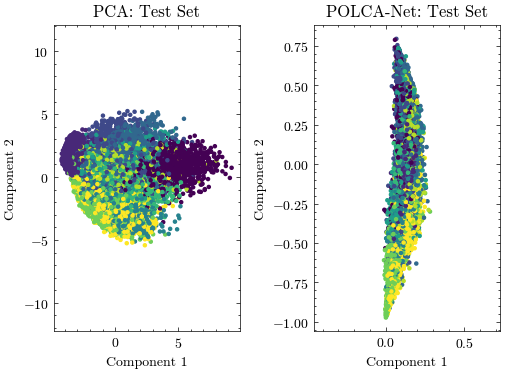

In [78]:
# Plotting the results
plt.figure()

# Plot PCA
plt.subplot(1, 2, 1)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap="viridis", edgecolor=None, s=5)
plt.title("PCA: Test Set")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.axis("equal")

# Plot POLCA-Net
plt.subplot(1, 2, 2)
plt.scatter(X_test_polca[:, 0], X_test_polca[:, 2], c=y_test, cmap="viridis", edgecolor=None, s=5)
plt.title("POLCA-Net: Test Set")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.axis("equal")

plt.tight_layout()
plt.show()